# 2D datasets with Mesh Neural Networks

### 0. Choose dataset

In [1]:
dataset = "spirals"

### 1. Import Libraries

In [2]:
from sklearn import datasets
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import IPython.display
from PIL import Image
rc('animation', html='html5')

### 2. Set MNN hyperparameters

In [3]:
inputs=2 + 1 # bias input
hidden=7
outputs=2 if dataset != "blobs" and dataset != "blobs2" else 3
batch_size=10
ticks = 3
epochs = 1500
lr = 0.001

samples=1000
test_perc = 0.3
noise = 0.1

### 3. Load dataset

In [4]:
if dataset == "moons":
    X, Y = datasets.make_moons(n_samples=samples, noise=noise)
elif dataset == "circles":
    X, Y = datasets.make_circles(n_samples=samples, noise=noise, factor=0.5)
elif dataset == "blobs":
    X, Y = datasets.make_blobs(n_samples=samples, cluster_std=[1.0, 2.5, 0.5])
elif dataset == "blobs2":
    X1, Y1 = datasets.make_blobs(n_samples=samples//2)
    X2, Y2 = datasets.make_blobs(n_samples=samples//2)

    X = np.concatenate((X1, X2))
    Y = np.concatenate((Y1, Y2))
elif dataset == "spirals":
    n = np.sqrt(np.random.rand(samples,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(samples,1) * noise
    d1y = np.sin(n)*n + np.random.rand(samples,1) * noise
    X, Y = (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(samples),np.ones(samples))))
else:
    raise Exception("Unknown dataset")

pivot = int(X.shape[0]*(1-test_perc))

train_X = X[:pivot]
train_Y = Y[:pivot]

test_X = X[pivot:]
test_Y = Y[pivot:]

### 4. Define utility functions

##### 4.1 ReLU Activation function and its derivative

In [5]:
def f(x, derivative=False):
    gt = (x > 0)
    if derivative:
        return 1 * gt
    else:
        return x * gt

#### 4.2 CrossEntropy loss function and its derivative

In [6]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.expand_dims(np.sum(exps, axis=1), axis=1)


def ce_loss(out, y, grad):
    y = y.astype(int)
    m = y.shape[0]
    p = softmax(out)
    log_likelihood = -np.log(p[range(m),y])
    loss = np.mean(log_likelihood, axis=0)

    de = p
    de[range(m),y] -= 1
    de = de/m
    de = np.expand_dims(np.expand_dims(de, axis=2), axis=2)
    grad = de*grad

    return (loss, grad.sum(axis=1).sum(axis=0))

#### 4.3 Adam Optimizer

In [7]:
class Adam:
    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0., **kwargs):
        
        allowed_kwargs = {'clipnorm', 'clipvalue'}
        for k in kwargs:
            if k not in allowed_kwargs:
                raise TypeError('Unexpected keyword argument '
                                'passed to optimizer: ' + str(k))

        self.__dict__.update(kwargs)
        self.iterations = 0
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.decay = decay
        self.epsilon = epsilon
        self.initial_decay = decay

    def step(self, params, grads):
        original_shapes = [x.shape for x in params]
        params = [x.flatten() for x in params]
        grads = [x.flatten() for x in grads]
        

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))

        t = self.iterations + 1
        lr_t = lr * (np.sqrt(1. - np.power(self.beta_2, t)) /
                     (1. - np.power(self.beta_1, t)))

        if not hasattr(self, 'ms'):
            self.ms = [np.zeros(p.shape) for p in params]
            self.vs = [np.zeros(p.shape) for p in params]
    
        ret = [None] * len(params)
        for i, p, g, m, v in zip(range(len(params)), params, grads, self.ms, self.vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * np.square(g)
            p_t = p - lr_t * m_t / (np.sqrt(v_t) + self.epsilon)
            self.ms[i] = m_t
            self.vs[i] = v_t
            ret[i] = p_t
        
        self.iterations += 1
        
        for i in range(len(ret)):
            ret[i] = ret[i].reshape(original_shapes[i])
        
        return ret


#### 4.4 Plotting

In [8]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(net, xx, yy, **params):
    input = np.c_[xx.ravel(), yy.ravel()]
    bs = input.shape[0]
    
    state = np.zeros(shape=(bs, neurons)) # Init state
    grad = np.zeros(shape=(bs, neurons, neurons, neurons)) # Init gradients
    
    for t in range(0, ticks):
        state, _ = net(state, grad, input, bs=bs, compute_grad=False)
        
    outs = state[:,inputs+hidden:neurons]
    Z = np.argmax(outs, axis=1).astype(int)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

 
def fig2data(fig):
    fig.canvas.draw()
 
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
 
    buf = np.roll(buf, 3, axis = 2)
    return buf

def fig2img(fig):
    buf = fig2data(fig)
    w, h, d = buf.shape
    return Image.frombytes("RGBA",(w ,h), buf.tostring())

def get_figure():
    fig = plt.figure()

    X0, X1 = train_X[:, 0], train_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    plot_contours(net, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X0, X1, c=train_Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ret = fig2img(fig)
    plt.close(fig)
    return ret

### 5. Define Mesh Neural Networks Functions

#### 5.1 FOP function as described in Section 2.2 of the paper

In [9]:
def derivate(grad, t):
    sn = np.zeros(shape=grad.shape)
    sn[:,np.eye(neurons).astype(bool)] = state[:,np.newaxis]
    sn = np.transpose(sn, (0,3,2,1))
    return f(t, derivative=True)[:, np.newaxis, np.newaxis] * (np.matmul(grad, A) + sn)

#### 5.2 State update function as described in Section 2.1 of the paper

In [10]:
def net(state, grad, x, bs=batch_size, compute_grad=True):
    # set inputs neurons state with input vector
    state[:,0:inputs] = np.concatenate((x, np.ones((bs,1))), axis=1)
    
    # compute ti
    t = np.matmul(state, A)
    
    # Forward propagate the gradients
    grad = derivate(grad, t) if compute_grad else None
    
    # Compute new state
    state = f(t)
    
    return state, grad

#### 5.3 Learning algorithm as described in Section 2.2.1 of the paper

epoch: 0  loss: 5.085141
epoch: 50  loss: 0.616959
epoch: 100  loss: 0.583152
epoch: 150  loss: 0.548342
epoch: 200  loss: 0.343124
epoch: 250  loss: 0.197952
epoch: 300  loss: 0.161359
epoch: 350  loss: 0.121376
epoch: 400  loss: 0.095786
epoch: 450  loss: 0.064127
epoch: 500  loss: 0.043824
epoch: 550  loss: 0.034114
epoch: 600  loss: 0.026477
epoch: 650  loss: 0.023128
epoch: 700  loss: 0.022933
epoch: 750  loss: 0.017043
epoch: 800  loss: 0.017234
epoch: 850  loss: 0.012081
epoch: 900  loss: 0.281040
epoch: 950  loss: 0.009276
epoch: 1000  loss: 0.006655
epoch: 1050  loss: 0.490068
epoch: 1100  loss: 0.002726
epoch: 1150  loss: 0.002117
epoch: 1200  loss: 0.001836
epoch: 1250  loss: 0.003380
epoch: 1300  loss: 0.002132
epoch: 1350  loss: 0.055572
epoch: 1400  loss: 0.000964
epoch: 1450  loss: 0.000897


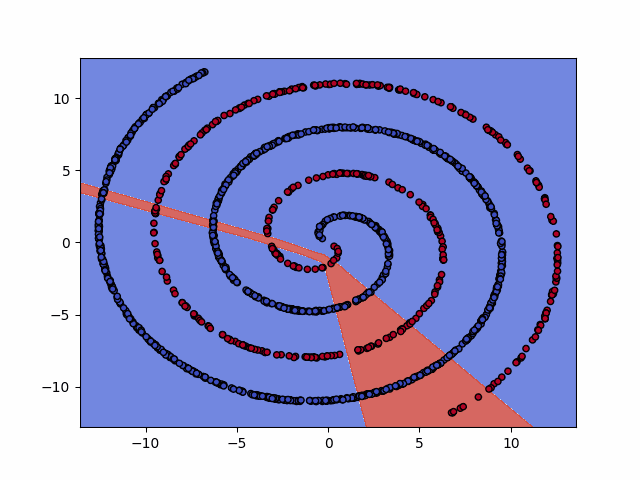

In [11]:
neurons = inputs + hidden + outputs
A = np.random.rand(neurons, neurons) # Adjacency Matrix

optimizer = Adam(lr=lr)
frames = []
for epoch in range(0, epochs):
    losses = 0
    for i in range(0, len(train_X)//batch_size):
        # Training batches
        batch_X = train_X[i*batch_size:(i+1)*batch_size]
        batch_Y = train_Y[i*batch_size:(i+1)*batch_size]
        
        state = np.zeros(shape=(batch_size, neurons)) # Init state
        grad = np.zeros(shape=(batch_size, neurons, neurons, neurons)) # Init gradients

        # Update MNN in time
        for t in range(0, ticks):
            state, grad = net(state, grad, batch_X)
        
        # Permute gradients for error function
        grad = np.transpose(grad, (0,3,1,2))
        
        # Slice output values and gradients
        outs = state[:,inputs+hidden:neurons]
        outs_grad = grad[:,inputs+hidden:neurons]
        
        # Compute loss and error gradients
        loss, err_grad = ce_loss(outs, batch_Y, outs_grad)
        losses += loss

        # Update weights
        A = optimizer.step(A, err_grad)
        
    if epoch % 50 == 0:
        print("epoch: %d  loss: %f" % (epoch, losses/(len(train_X)//(batch_size))))
        frames.append(get_figure())

frames[0].save(dataset+'_training.gif', format='GIF', append_images=frames[1:],
               save_all=True, duration=100, loop=0)
IPython.display.Image(dataset+"_training.gif")

![moons_training](spirals_training.gif)

### 6. Test the model

In [12]:
rights = 0
tots = 0
for i in range(0, len(test_X)//batch_size):
    # Testing batches
    batch_X = test_X[i*batch_size:(i+1)*batch_size]
    batch_Y = test_Y[i*batch_size:(i+1)*batch_size]
    
    # Init MNN
    state = np.zeros(shape=(batch_size, neurons))
    grad = np.zeros(shape=(batch_size, neurons, neurons, neurons))
    
    for t in range(0, ticks):
        state, grad = net(state, grad, batch_X)
    outs = state[:,inputs+hidden:neurons]
    
    rights += (np.argmax(outs, axis=1) == batch_Y).astype(int).sum()   
    tots += batch_size
    
print("Accuracy: %f" % (rights/tots) )

Accuracy: 1.000000
